In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime as dt

from tools_fast import *
from hc_graph import hc_stock
sns.set()

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True,
                     dayfirst=True)[['BNPIFEU','BNPIFE10',"SPGSGCP","BPFXCAD1"]]
#prices_risk_premia = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, 
#                                 dayfirst=True)[["BNPIMDEA"]]


#prices = pd.concat([prices_index, prices_risk_premia],axis=1).dropna()
returns = prices.pct_change().dropna()

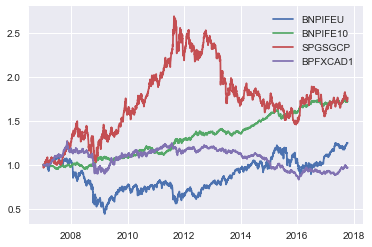

In [4]:
(prices/prices.iloc[0]).plot()

In [5]:
returns.corr(method="pearson")

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
BNPIFEU,1.000000,-0.472742,0.005528,0.477899
BNPIFE10,-0.472742,1.000000,0.096560,-0.247564
SPGSGCP,0.005528,0.096560,1.000000,0.282960
BPFXCAD1,0.477899,-0.247564,0.282960,1.000000


In [6]:
#random rebalancing dates
# n_reweight = 100
# reweight_cal = returns.sample(n_reweight).sort_index().index
# df_reweight = pd.DataFrame(index=reweight_cal, data=np.random.normal(0.3, 0.3, size=(n_reweight, len(prices.columns))),
#                             columns=prices.columns)
# df_reweight.to_pickle("df_reweight.pkl")
# df_reweight = pd.read_pickle("df_reweight.pkl")

In [7]:
#non random rebalancing dates
n_reweight = 250
n = len(returns.index)
df_reweight = pd.DataFrame(index=[returns.index[int(i * n / n_reweight)] for i in range(n_reweight)], columns=prices.columns,
                           data=np.random.normal(0.3, 0.3, size=(n_reweight, len(prices.columns))))
df_reweight.to_pickle("df_reweight2.pkl")
df_reweight = pd.read_pickle("df_reweight2.pkl")

In [8]:
df_reweight.head()

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
2007-01-04,-0.028854,0.246791,0.660095,0.205273
2007-01-19,0.340842,0.029963,0.315298,-0.123885
2007-02-05,0.378055,0.166804,-0.363687,-0.006006
2007-02-20,0.843726,0.357697,0.483440,-0.022637
2007-03-07,0.488285,0.080265,0.390907,0.917730


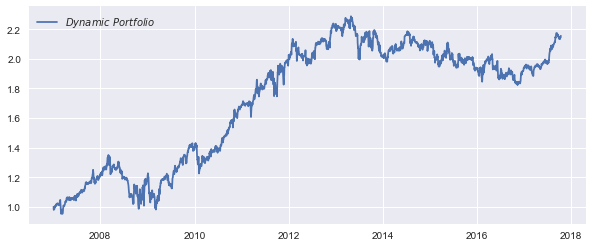

In [9]:
track = make_track(prices.loc[df_reweight.index[0]:], df_reweight, lag=0).rename(columns={'Track':'$Dynamic\ Portfolio$'})
track.plot(figsize=(10,4))

In [10]:
## Replication Data
track_returns = track.pct_change().dropna()
universe_returns = returns.loc[track_returns.index]

freq = 1

In [11]:
df_res = track.loc['2009':].copy()

In [12]:
%%time
nu = 0.005
df_weight_kalman = kalman_filter(track_returns, universe_returns, freq, sigma_weight=1., sigma_return=nu)
prices_for_track_kalman = prices.loc[df_weight_kalman.index[0]:]
replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
df_res["$Kalman\ \\nu={}\ daily\ rebalancing$".format(nu)] = replication_kalman

Wall time: 348 ms


In [13]:
%%time
tau_diag = 0.1
for freq_ml in [1, 5, 10, 20, 40, 60]:
    df_weight_ml_kalman_diag = ml_kalman_filter_diag(track_returns, universe_returns, freq_ml, tau=tau_diag)
    prices_for_track_ml_kalman_diag = prices.loc[df_weight_ml_kalman_diag.index[0]:]
    replication_ml_kalman_diag = make_track(prices_for_track_ml_kalman_diag, df_weight_ml_kalman_diag).loc[df_res.index[0]:]
    df_res["$ML\ Diag\ Kalman\ {}-day\ rebalancing$".format(freq_ml)] = replication_ml_kalman_diag

Wall time: 9min 13s


In [14]:
%%time
tau = 0.1
for freq_ml in [1, 5, 10, 20, 40, 60]:
    df_weight_ml_kalman, _ = ml_kalman_filter(track_returns, universe_returns, freq_ml, tau=tau)
    prices_for_track_ml_kalman = prices.loc[df_weight_ml_kalman.index[0]:]
    replication_ml_kalman = make_track(prices_for_track_ml_kalman, df_weight_ml_kalman).loc[df_res.index[0]:]
    df_res["$ML\ Kalman\ {}-day\ rebalancing$".format(freq_ml)] = replication_ml_kalman

Wall time: 4min 21s


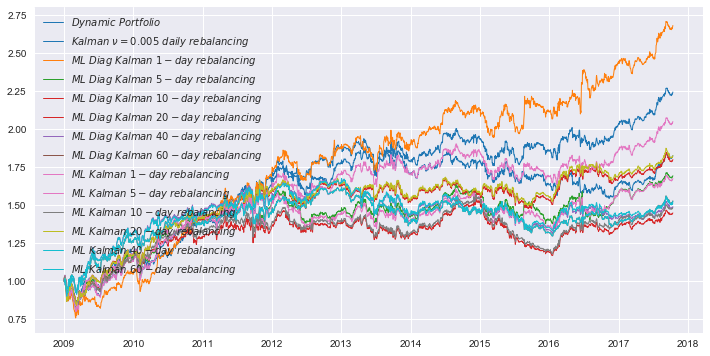

In [15]:
df_res = (df_res / df_res.iloc[0])
df_res.plot(figsize=(12,6),linewidth=1, cmap='tab10')

In [16]:
g = hc_stock(df_res)
g.plot()

In [17]:
df_stat2 = replication_stats(df_res, fund_name='$Dynamic\ Portfolio$')
df_stat2

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
$Dynamic\ Portfolio$,0.000000,1.000000,0.582727,0.068404,1.000000,1.000000
$Kalman\ \nu=0.005\ daily\ rebalancing$,0.004517,0.683965,0.748479,0.092962,0.845260,0.716117
$ML\ Diag\ Kalman\ 1-day\ rebalancing$,0.006205,0.403692,0.843732,0.114592,0.733375,0.605197
$ML\ Diag\ Kalman\ 5-day\ rebalancing$,0.006269,0.391277,0.503786,0.059606,0.707335,0.584062
$ML\ Diag\ Kalman\ 10-day\ rebalancing$,0.006716,0.301503,0.394993,0.041563,0.635691,0.495948
$ML\ Diag\ Kalman\ 20-day\ rebalancing$,0.006351,0.375268,0.633043,0.066732,0.652744,0.491553
$ML\ Diag\ Kalman\ 40-day\ rebalancing$,0.006242,0.396454,0.444870,0.044808,0.666535,0.506004
$ML\ Diag\ Kalman\ 60-day\ rebalancing$,0.006206,0.403504,0.489202,0.047640,0.659671,0.513684
$ML\ Kalman\ 1-day\ rebalancing$,0.004677,0.661255,0.674859,0.082139,0.833127,0.700547
$ML\ Kalman\ 5-day\ rebalancing$,0.006054,0.432308,0.498670,0.058312,0.723551,0.589197
